# Linear Regression Playground

## Setup & Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import SeedSequence, default_rng

# True function
def f_true(x):
    return 10 * (x**2)*(x-0.5)

# Generate ONE dataset (train only)
def generate_dataset(rng, f_true, 
                     x_min=0.0, x_max=10.0, 
                     n_train=10, sigma=2.0):
    x_train = rng.uniform(x_min, x_max, size=n_train)
    noise_train = rng.normal(0.0, sigma, size=n_train)
    y_train = f_true(x_train) + noise_train
    return {"x_train": x_train, "y_train": y_train}

# Utility
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Generate MANY datasets in memory (list of dicts)
def make_many_datasets_in_memory(f_true,
                                 n_reps,
                                 x_min=-1, x_max=1,
                                 n_train=20, sigma=2.0,
                                 base_seed=12345):
    ss = SeedSequence(base_seed)
    child_seeds = ss.spawn(n_reps)

    datasets = []
    for cs in child_seeds:
        rng = default_rng(cs)
        d = generate_dataset(rng, f_true, x_min, x_max, n_train, sigma)
        datasets.append(d)
    return datasets

# --- example usage ---
n_reps = 1000 # number of training datasets
x_min, x_max = -0.2, 0.6
sigma = 0.05
n_train = 20
datasets = make_many_datasets_in_memory(f_true, n_reps=n_reps, x_min = x_min, x_max = x_max, n_train=n_train, sigma=sigma, base_seed=12345)
print(datasets[0]["x_train"].shape, datasets[0]["y_train"].shape)  

(20,) (20,)


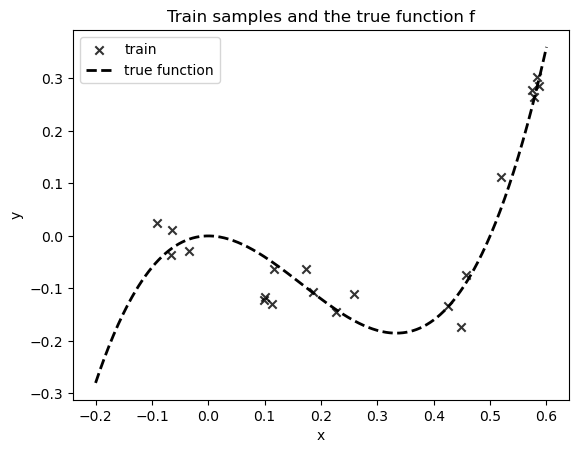

In [2]:
# Choose a dataset to plot
dataset_num = 3
x_train = datasets[dataset_num]["x_train"]
y_train = datasets[dataset_num]["y_train"]

# Plot train & test dat
xs = np.linspace(x_min, x_max, 400)
plt.figure()
plt.scatter(x_train, y_train, label="train", alpha=0.8, color = 'k', marker = 'x')
plt.plot(xs, f_true(xs), label="true function", linewidth=2, color = 'k', linestyle= '--')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train samples and the true function f")
plt.legend()
plt.show()

## Polynomial expansions

In [3]:
def make_vandermonde(x, d):
    # Columns: x^0, x^1, ..., x^{d-1}
    powers = [np.ones_like(x)]
    for k in range(1, d+1):
        powers.append(powers[-1] * x)
    return np.column_stack(powers)

def fit_pinv(X, y):
    # think of np.linalg.pinv(X)  as computing X.T (X X.T)^{-1} or (X.T X)^{-1} X.T depending on d < n or not 
    return np.linalg.pinv(X) @ y

## Polynomial expansions

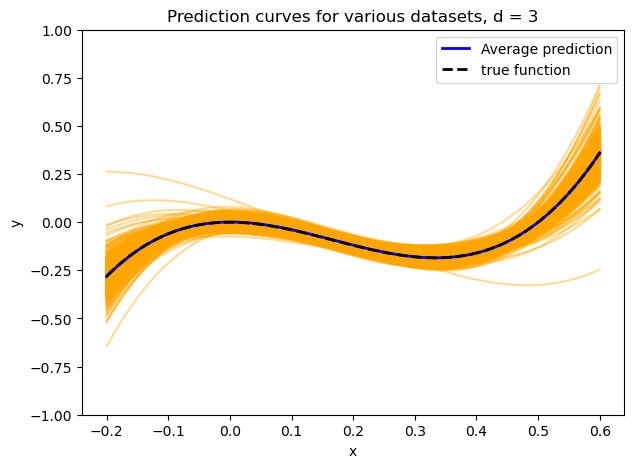

In [7]:
# Degrees to evaluate/plot
d = 3

train_mse_by_dataset = []

xs_dense = np.linspace(x_min, x_max, 400)
Xd_dense = make_vandermonde(xs_dense, d)

fig, ax = plt.subplots(figsize=(7, 5))

# Collect predictions for averaging
all_preds = []

for dataset in datasets:
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    Xd_train = make_vandermonde(x_train, d)
    w = fit_pinv(Xd_train, y_train)
    y_pred_dense = Xd_dense @ w
    
    all_preds.append(y_pred_dense)  # save for later averaging
    train_mse_by_dataset.append(mse(y_train, Xd_train @ w))
    
    # Plot each individual dataset curve
    ax.plot(xs_dense, y_pred_dense, color="orange", alpha=0.4)

# Compute and plot the average curve
avg_pred = np.mean(all_preds, axis=0)
ax.plot(xs_dense, avg_pred, color="blue", linewidth=2.0, label="Average prediction")
ax.plot(xs, f_true(xs), label="true function", linewidth=2, color = 'k', linestyle= '--')
ax.set_ylim((-1, 1))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Prediction curves for various datasets, d = {d}")
ax.legend()
plt.show()

# Demonstrating the bias-variance decomposition

max | total_avg - (bias^2_avg + var_avg) | = 2.7755575615628914e-17


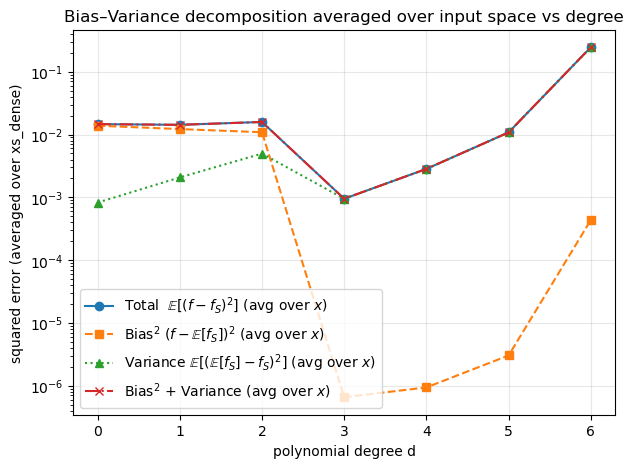

In [6]:
# --- Bias–Variance averaged over xs_dense, vs degree ---

# Degrees to sweep
degrees = list(range(0, 7))  # adjust as you like

n_test = 400
xs_dense = np.random.uniform(x_min, x_max, size=n_test)
f_dense = f_true(xs_dense)  # true values on the test set


bias_sq_avg_list = []
var_avg_list = []
total_avg_list = []
sum_avg_list = []

for d in degrees:
    # Predict on the dense grid for every dataset
    preds_dense = []
    for dataset in datasets:
        x_train = dataset["x_train"]
        y_train = dataset["y_train"]
        Xd_train = make_vandermonde(x_train, d)
        w = fit_pinv(Xd_train, y_train)

        Xd_dense = make_vandermonde(xs_dense, d)
        preds_dense.append(Xd_dense @ w)

    preds_dense = np.stack(preds_dense, axis=0)  # shape: (num_datasets, len(xs_dense))
    mean_pred_dense = preds_dense.mean(axis=0)

    # Pointwise components on xs_dense
    bias_sq_curve = (f_dense - mean_pred_dense) ** 2
    var_curve = ((preds_dense - mean_pred_dense[None, :]) ** 2).mean(axis=0)
    total_curve = ((f_dense[None, :] - preds_dense) ** 2).mean(axis=0)

    # Average over xs_dense (uniform weighting)
    bias_sq_avg = bias_sq_curve.mean()
    var_avg = var_curve.mean()
    total_avg = total_curve.mean()

    bias_sq_avg_list.append(bias_sq_avg)
    var_avg_list.append(var_avg)
    total_avg_list.append(total_avg)
    sum_avg_list.append(bias_sq_avg + var_avg)

# Numeric check across degrees
diff = np.abs(np.array(total_avg_list) - np.array(sum_avg_list))
print("max | total_avg - (bias^2_avg + var_avg) | =", float(diff.max()))

# Plot vs degree
fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(degrees, total_avg_list, marker="o", label=r"Total  $\mathbb{E}[(f-f_S)^2]$ (avg over $x$)")
ax.semilogy(degrees, bias_sq_avg_list, marker="s", linestyle="--", label=r"Bias$^2$ $(f-\mathbb{E}[f_S])^2$ (avg over $x$)")
ax.semilogy(degrees, var_avg_list, marker="^", linestyle=":", label=r"Variance $\mathbb{E}[(\mathbb{E}[f_S]-f_S)^2]$ (avg over $x$)")
ax.semilogy(degrees, sum_avg_list, marker="x", linestyle="-.", label=r"Bias$^2$ + Variance (avg over $x$)")

ax.set_xlabel("polynomial degree d")
ax.set_ylabel("squared error (averaged over xs_dense)")
ax.set_title("Bias–Variance decomposition averaged over input space vs degree")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
